# Building a model

Lilith lets you define models as callable, possibly nested structs containing model parameters. There are no special wrappers, type hierarchies or initialization rules - any structure with numbers or arrays should work. In this tutorial we will consider several approaches, going from all custom elements to Lilith's built-in layers and functions. 

For this tutorial you need packages `HTTP`, `DataFrames`, `Plots` and `MLDataUtils`. Install them from Julia console using `] add PkgName`.

## Dataset

For demonstration purposes we will use very simple dataset with only 11 predictors and 1 respose variable - [wine quality dataset](https://archive.ics.uci.edu/ml/datasets/wine+quality). Using these data, one can predict wine quality based on its acidity, density, pH, etc. Here's how we can get the dataset: 

In [2]:
using HTTP
using DataFrames

io = IOBuffer(HTTP.request("GET", "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv").body)
df = readtable(io, separator=';');

In [3]:
DataFrames.describe(df)

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Float64,Real,Float64,Real,Nothing,Int64,Union
1,fixed_acidity,8.31964,4.6,7.9,15.9,,0,"Union{Missing, Float64}"
2,volatile_acidity,0.527821,0.12,0.52,1.58,,0,"Union{Missing, Float64}"
3,citric_acid,0.270976,0.0,0.26,1.0,,0,"Union{Missing, Float64}"
4,residual_sugar,2.53881,0.9,2.2,15.5,,0,"Union{Missing, Float64}"
5,chlorides,0.0874665,0.012,0.079,0.611,,0,"Union{Missing, Float64}"
6,free_sulfur_dioxide,15.8749,1.0,14.0,72.0,,0,"Union{Missing, Float64}"
7,total_sulfur_dioxide,46.4678,6.0,38.0,289.0,,0,"Union{Missing, Float64}"
8,density,0.996747,0.99007,0.99675,1.00369,,0,"Union{Missing, Float64}"
9,pH,3.31111,2.74,3.31,4.01,,0,"Union{Missing, Float64}"


Just to get a sense of data, here's a quick view at one of predictor variables (feel free to play aroud with others):

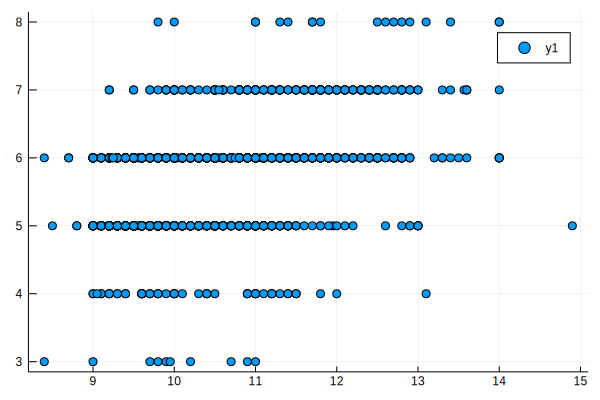

In [4]:
using Plots

scatter(df.alcohol, df.quality)

We will use first 11 columns of the dataframe as features and the last one (quality) as predicted variable. Note that Lilith, as well as most ML libraries in Julia, expects features in rows and observations in columns, so we also need to transpose the data. 

In [4]:
X = convert(Matrix{Float64}, df[!, 1:11])' |> copy
y = convert(Vector{Float64}, df[!, 12])

1599-element Array{Float64,1}:
 5.0
 5.0
 5.0
 6.0
 5.0
 5.0
 5.0
 7.0
 7.0
 5.0
 5.0
 5.0
 5.0
 ⋮  
 6.0
 6.0
 5.0
 6.0
 6.0
 6.0
 6.0
 5.0
 6.0
 6.0
 5.0
 6.0

## Model and how to train it

Now let's define our regression model and corresponding loss function:

In [5]:
# model struct
mutable struct WineQualityRegression
    W::AbstractMatrix
    b::AbstractVector
end

# short constructor for convenience
WineQualityRegression() = WineQualityRegression(randn(1, 11), randn(1))

# forward pass of the model
(m::WineQualityRegression)(x) = m.W * x .+ m.b

# loss - mean squared difference between predicted and true value
wine_quality_loss(m::WineQualityRegression, X::AbstractMatrix, y::AbstractVector) = mean((m(X) .- y).^2)

wine_quality_loss (generic function with 1 method)

Training the model boils down to iterating through batches of data, calculating gradient of the loss w.r.t. its parameters and updating them: 

In [6]:
using Lilith
using MLDataUtils
using Statistics


function train!(m::WineQualityRegression, X::AbstractArray, Y::AbstractArray)
    opt = Adam(lr=1e-4)
    num_batches = size(X)[end] // 100  # batch_size
    for epoch=1:10_000
        epoch_loss = 0        
        for (x, y) in eachbatch((X, Y), size=100)         
            loss, g = grad(wine_quality_loss, m, x, y)
            update!(opt, m, g[1])
            epoch_loss += loss
        end
        if epoch % 1000 == 0
            println("Epoch $epoch: avg_loss=$(epoch_loss / num_batches)")
        end
    end
end

train! (generic function with 1 method)

Two most important lines in the code above are 
```
loss, g = grad(win_quality_loss, m, x, y)
update!(opt, m, g[1])
```
The first one calculates value of `win_quality_loss` and its gradient w.r.t. it parameters, while the second one updates fields of the model `m` with corresponding gradient `g[1]`. Also note the first argument to `update!` - `opt`, an optimizer which controls steps size by which each parameter will be changed. 

Now let's train the model and see how the value of loss function falls down.

In [7]:
m = WineQualityRegression()

train!(m, X, y)

┌ Warning: The specified values for size and/or count will result in 99 unused data points
└ @ MLDataPattern /home/slipslop/.julia/packages/MLDataPattern/mX21p/src/dataview.jl:204
┌ Warning: Gradient %33 has size (100, 100), but original variable %10 has size (1, 100)
└ @ Yota /home/slipslop/.julia/packages/Yota/eGqxh/src/grad.jl:227
┌ Warning: Gradient %35 has size (100, 100), but original variable %3 has size (100,)
└ @ Yota /home/slipslop/.julia/packages/Yota/eGqxh/src/grad.jl:227


Epoch 1000: avg_loss=11.746070748394448
Epoch 2000: avg_loss=0.7479868594587693
Epoch 3000: avg_loss=0.6784342770731261
Epoch 4000: avg_loss=0.6648490645841495
Epoch 5000: avg_loss=0.6560062787654264
Epoch 6000: avg_loss=0.6497299934910553
Epoch 7000: avg_loss=0.6451798249853012
Epoch 8000: avg_loss=0.641822037624411
Epoch 9000: avg_loss=0.6392994006208397
Epoch 10000: avg_loss=0.637368102957487


## Exploring Lilith API

Although you can create a model using only arrays and custom Julia functions, it's often easier to utilize more high-level building blocks. For example, our wine quality regression can be rewritten into:

In [8]:
using Lilith

# model struct
mutable struct WineQualityRegression2
    linear::Linear          # linear layer which already contains a matrix of weights and a vector of biases
end

WineQualityRegression2() = WineQualityRegression2(Linear(11 => 1))

(m::WineQualityRegression2)(x) = m.linear(x)


m = WineQualityRegression2()

fit!(m, X, y', MSELoss(); opt=Adam(lr=1e-4), n_epochs=10_000, report_every=1000)

Epoch 1000: avg_loss=0.42837037728664606
Epoch 2000: avg_loss=0.4151687565461038
Epoch 3000: avg_loss=0.40941620264223766
Epoch 4000: avg_loss=0.40657481713895394
Epoch 5000: avg_loss=0.40510300800989557
Epoch 6000: avg_loss=0.4042863325226975
Epoch 7000: avg_loss=0.4037859530391865
Epoch 8000: avg_loss=0.4034406757392981
Epoch 9000: avg_loss=0.4031733973249541
Epoch 10000: avg_loss=0.40294694684683147


WineQualityRegression2(Linear(11=>1))

Here's what changed:

 * parameters `W` and `b` were replaced with a single layer `linear`
 * we used built-in `MSELoss()` instead of specifying loss function manually
 * instead of writing our own `train!()` we utilized Lilith's `fit!()` function

> **WARNING:** function `fit!()` is still in active development and is not covered by backward compatibility guarantees!

## CPU vs. GPU

Lilith supports training and inference not only on CPU, but also on NVIDIA GPU (using well-known CuArrays library). The API is device-agnostic and boils down to:

 * instantiating required device using `CPU()`, `GPU()` or `best_available_device()` which automatically selects GPU if available or CPU otherwise
 * applying device object to model and data (if needed)
 
Here's how we can modify the previous example to work with the fastest device available on your system: 

In [13]:
using Lilith

mutable struct WineQualityRegression2
    linear::Linear
end

WineQualityRegression2() = WineQualityRegression2(Linear(11 => 1))

# forward pass of the model
(m::WineQualityRegression2)(x) = m.linear(x)

device = best_available_device()
m = WineQualityRegression2() |> device

fit!(m, X, y', MSELoss(); opt=Adam(lr=1e-4), n_epochs=10_000, report_every=1000, device=device)

Epoch 1000: avg_loss=0.45827338
Epoch 2000: avg_loss=0.4281992
Epoch 3000: avg_loss=0.41599974
Epoch 4000: avg_loss=0.40996405
Epoch 5000: avg_loss=0.40687665
Epoch 6000: avg_loss=0.4052266
Epoch 7000: avg_loss=0.4042875
Epoch 8000: avg_loss=0.40370646
Epoch 9000: avg_loss=0.40331066
Epoch 10000: avg_loss=0.4030129


WineQualityRegression2(Linear(11=>1))

Here's what changed:

 * we instantiated device using `device = best_available_device()` which returns GPU() if CUDA is set up on the computer or CPU() otherwise
 * model was created and immediately converted to device using `m = WineQualityRegression2() |> device`; all `Array` parameters were replaced with `CuArray`s
 * we also passed device as additional argument to the `fit!()` function to convert each incoming batch to that device

Note that even though `fit!()` takes care of converting batches of data to device during training, for inference you will need to do it manually:

In [14]:
x_sample = X[:, 1:10] |> device
m(x_sample)

1×10 CuArrays.CuArray{Float32,2}:
 5.12101  5.03766  5.15622  5.71932  …  5.07539  5.30108  5.31044  5.65114